In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import seaborn as sns
import zipfile
import io
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### MPG DATA ###

In [3]:
#   load mpg data
mpg_path = '/Users/elvissmith/Desktop/COGS_118A/FInal project/auto+mpg.zip'
with zipfile.ZipFile(mpg_path, 'r') as zip_ref:
    with zip_ref.open('auto-mpg.data') as file:
        mpg = pd.read_csv(file, sep='\s+')
columns = [
    'mpg','cylinders', 'displacement',
    'horsepower','weight', 'acceleration',
    'model_year','origin', 'car_name'
    ]
mpg.columns = columns

#   drop missing values
mpg.replace("?", np.nan, inplace=True)

#   split dataset into two classes (high mpg vs low mpg) with the threshold being the median mpg of all cars
mpg_threshold = mpg['mpg'].median() # threshold
mpg['Y'] = mpg['mpg'].apply(lambda x: 1 if x >= mpg_threshold else -1)

#   drop Y and car_names columns before normalizing
yM = mpg['Y']
cM = mpg['car_name']
mpg = mpg.drop(columns = ["Y",'car_name'])

#  normalize data to avoid disproportionate influence 
scaler = StandardScaler()
mpg_scaled = scaler.fit_transform(mpg)
mpg = pd.DataFrame(mpg_scaled, columns = mpg.columns)

#   add car names and Y back to mpg data (car_names will only be used at the end as labels for points)
mpg["Y"] = yM
mpg['car_name'] = cM

In [4]:
#   drop car_names since its
mpg.dropna(inplace = True)
XM = mpg.drop(columns = ['car_name', 'Y','mpg'])
YM = mpg['Y']

### ABALONE DATA ###

In [5]:
#   load abalone data
abalone_path = '/Users/elvissmith/Desktop/COGS_118A/FInal project/abalone.zip'
with zipfile.ZipFile(abalone_path, 'r') as zip_ref:
    with zip_ref.open('abalone.data') as file:
        abalone = pd.read_csv(file)
columns = [
    "Sex", "Length", "Diameter", "Height", 
    "WholeWeight", "ShuckedWeight", 
    "VisceraWeight", "ShellWeight", "Rings"
]
abalone.columns = columns

#   slip the dataset into two classes (young vs old) with the threshold for age being the median
abalone_threshold = abalone['Rings'].median() # defines classifier threshold
abalone['Y'] = abalone['Rings'].apply(lambda x: 1 if x >= abalone_threshold else -1)
abalone = abalone.drop(columns = ['Sex']) # drop catagorical data for simplicity

#   take Y and Rings column out so its not normalized
yA = abalone['Y']
rA = abalone['Rings']
abalone = abalone.drop(columns = ['Y','Rings'])

#   noramlize the numercal values so that it can't be disproportionately influenced
scaler = StandardScaler()
abalone_scaled = scaler.fit_transform(abalone)
abalone = pd.DataFrame(abalone_scaled, columns=abalone.columns)

#   add Y Rings column back to abalone (Rings will be used as labels at the end)
abalone['Y'] = yA
abalone['Rings'] = rA

In [6]:
XA = abalone.drop(columns = ['Rings','Y']) # values without classifier
YA = abalone["Y"]

### IRIS DATA ###

In [7]:
#   load in iris data 
iris = datasets.load_iris()
XI = iris.data
XI.view()

#   each instance is an individual plant
#   150 entries are partitioned into 3 different types of iris plant (50 each)
#   
#   we will divide the 3 types into two different classes:
#       Y = -1: Setosa and Versicolor 
#       Y = 1: Virginica
YI = (iris.target > 1.5).reshape(-1,1).astype(float)
YI[YI==0] = -1 # for cases of zero values

In [8]:
# combine X and Y values onto same array
XI_YI = np.hstack((XI,YI))
np.random.seed(1)
np.random.shuffle(XI_YI) # shuffles the data point so the plant types aren't seprated
XI_shuffled = XI_YI[:,:4] # shuffled just the first 4 columns of X_Y
YI_shuffled = XI_YI[:,4] 

### Decision Tree Parameters ###

In [12]:
param_grid = {'max_depth': (2, 4, 6, 8, 10),
              'criterion': ('gini', 'entropy'),
              'max_features': ('sqrt', 'log2'),
              'min_samples_split': (2, 4, 6, 8, 10)
              }

def run_grid_search(X_train, Y_train, parameters, cv=5,):
    dt = DecisionTreeClassifier(random_state=1) 
    
    # Initialize GridSearchCV
    dt_grid = GridSearchCV(
        estimator=dt,
        param_grid=parameters,
        cv=cv,
    )
    dt_grid.fit(X_train, Y_train)
    return dt_grid.best_estimator_, dt_grid, dt

### Optimal Iris Data Hyper Parameters

In [13]:
#   (80/20)
XI_train_80, XI_test_20, YI_train_80, YI_test_20 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.2, random_state=1)
#   (20/80)
XI_train_20, XI_test_80, YI_train_20, YI_test_80 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.8, random_state=1)
#   (50/50)
XI_train_50, XI_test_50, YI_train_50, YI_test_50 = train_test_split(XI_shuffled, YI_shuffled, test_size=0.5, random_state=1)

In [14]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, dt_grid_80_20, dt = run_grid_search(XI_train_80, YI_train_80, param_grid);
test_accuracy = dt_grid_80_20.score(XI_test_20, YI_test_20)
train_predictions = dt_grid_80_20.predict(XI_train_80)
train_accuracy = accuracy_score(YI_train_80, train_predictions)
cv_scores = cross_val_score(dt, XI_train_80, YI_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=1)
Test Accuracy (80/20): 0.933
Train Accuracy (80/20): 0.9916666666666667
Cross Validation Scores: [0.91666667 0.95833333 1.         0.95833333 0.875     ]


In [16]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, dt_grid_20_80, dt = run_grid_search(XI_train_20, YI_train_20, param_grid);
test_accuracy = dt_grid_20_80.score(XI_test_80, YI_test_80)
train_predictions = dt_grid_20_80.predict(XI_train_20)
train_accuracy = accuracy_score(YI_train_20, train_predictions)
cv_scores = cross_val_score(dt, XI_train_20, YI_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (20/80): DecisionTreeClassifier(max_depth=2, max_features='sqrt', random_state=1)
Test Accuracy (20/80): 0.950
Train Accuracy (20/80): 1.0
Cross Validation Scores: [1.         1.         0.83333333 1.         0.83333333]


In [18]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, dt_grid_50_50, dt = run_grid_search(XI_train_50, YI_train_50, param_grid);
test_accuracy = dt_grid_50_50.score(XI_test_50, YI_test_50)
train_predictions = dt_grid_50_50.predict(XI_train_50)
train_accuracy = accuracy_score(YI_train_50, train_predictions)
cv_scores = cross_val_score(dt, XI_train_50, YI_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f'Train Accuracy (50/50): {train_accuracy:.3f}')
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (50/50): DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=1)
Test Accuracy (50/50): 0.947
Train Accuracy (50/50): 1.000
Cross Validation Scores: [1.         0.93333333 0.86666667 0.93333333 1.        ]


### Heat Maps for each Iris Partition

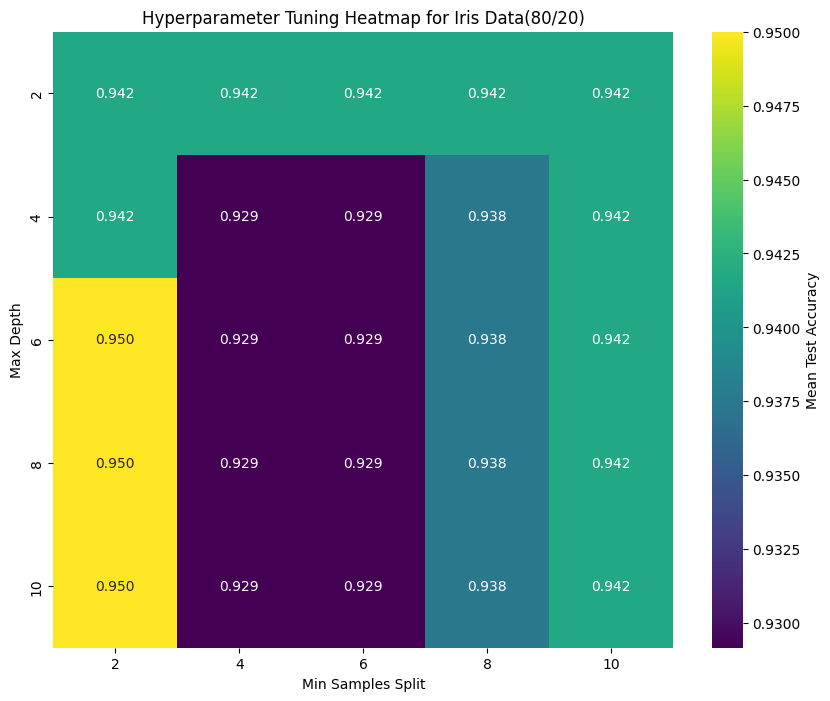

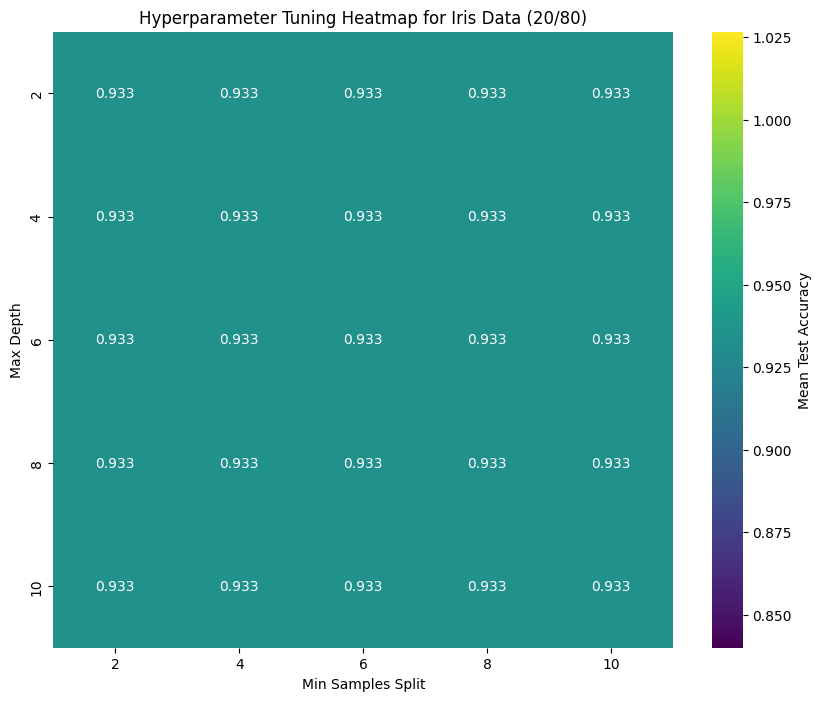

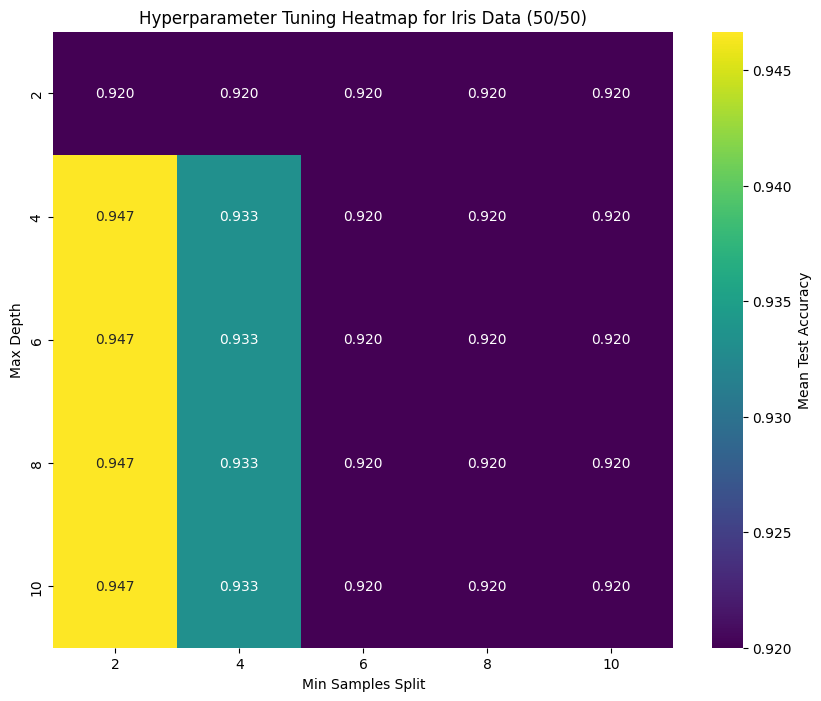

In [19]:
results_80_20 = pd.DataFrame(dt_grid_80_20.cv_results_)
heatmap_data = results_80_20.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for Iris Data(80/20)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

results_20_80 = pd.DataFrame(dt_grid_20_80.cv_results_)
heatmap_data = results_20_80.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for Iris Data (20/80)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

results_50_50 = pd.DataFrame(dt_grid_50_50.cv_results_)
heatmap_data = results_50_50.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for Iris Data (50/50)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

### Accuracy Curve for each Iris Partition

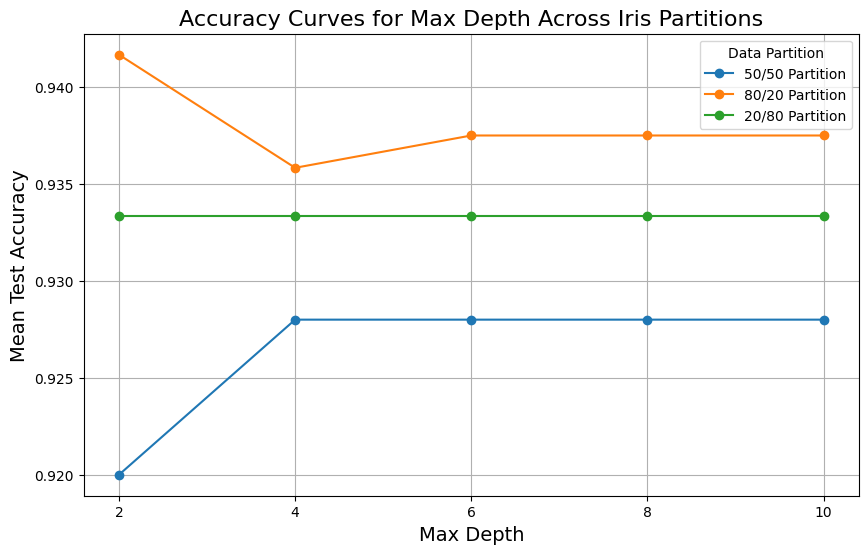

In [20]:
partitions = {
    '50/50': results_50_50,
    '80/20': results_80_20,
    '20/80': results_20_80
}

plt.figure(figsize=(10, 6))

for partition_name, results in partitions.items():
    # Group results by max_depth and calculate mean test score
    accuracy_curve_data = results.groupby('param_max_depth')['mean_test_score'].mean()
    
    # Plot the accuracy curve for the current partition
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition'
    )

# Add labels, title, legend, and grid
plt.title('Accuracy Curves for Max Depth Across Iris Partitions', fontsize=16)
plt.xlabel('Max Depth', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)  # Ensure x-ticks match max_depth values
plt.show()

### Optimal Abalone Data Hyper Parameters

In [21]:
#   (80/20)
XA_train_80, XA_test_20, YA_train_80, YA_test_20 = train_test_split(XA, YA, test_size=0.2, random_state=1)
#   (20/80)
XA_train_20, XA_test_80, YA_train_20, YA_test_80 = train_test_split(XA, YA, test_size=0.8, random_state=1)
#   (50/50)
XA_train_50, XA_test_50, YA_train_50, YA_test_50 = train_test_split(XA, YA, test_size=0.5, random_state=1)

In [22]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, dt_grid_80_20, dt = run_grid_search(XA_train_80, YA_train_80, param_grid);
test_accuracy = dt_grid_80_20.score(XA_test_20, YA_test_20)
train_predictions = dt_grid_80_20.predict(XA_train_80)
train_accuracy = accuracy_score(YA_train_80, train_predictions)
cv_scores = cross_val_score(dt, XA_train_80, YA_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_split=10,
                       random_state=1)
Test Accuracy (80/20): 0.830
Train Accuracy (80/20): 0.8470059880239521
Cross Validation Scores: [0.81287425 0.77245509 0.77994012 0.75748503 0.74850299]


In [23]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, dt_grid_20_80, dt = run_grid_search(XA_train_20, YA_train_20, param_grid);
test_accuracy = dt_grid_20_80.score(XA_test_80, YA_test_80)
train_predictions = dt_grid_20_80.predict(XA_train_20)
train_accuracy = accuracy_score(YA_train_20, train_predictions)
cv_scores = cross_val_score(dt, XA_train_20, YA_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (20/80): DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       random_state=1)
Test Accuracy (20/80): 0.805
Train Accuracy (20/80): 0.8167664670658683
Cross Validation Scores: [0.78443114 0.77844311 0.81437126 0.80239521 0.77245509]


In [24]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, dt_grid_50_50, dt = run_grid_search(XA_train_50, YA_train_50, param_grid);
test_accuracy = dt_grid_50_50.score(XA_test_50, YA_test_50)
train_predictions = dt_grid_50_50.predict(XA_train_50)
train_accuracy = accuracy_score(YA_train_50, train_predictions)
cv_scores = cross_val_score(dt, XA_train_50, YA_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f'Train Accuracy (50/50): {train_accuracy:.3f}')
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (50/50): DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       random_state=1)
Test Accuracy (50/50): 0.830
Train Accuracy (50/50): 0.826
Cross Validation Scores: [0.77033493 0.78229665 0.78229665 0.78417266 0.76258993]


### Heat Maps for each Abalone Partition

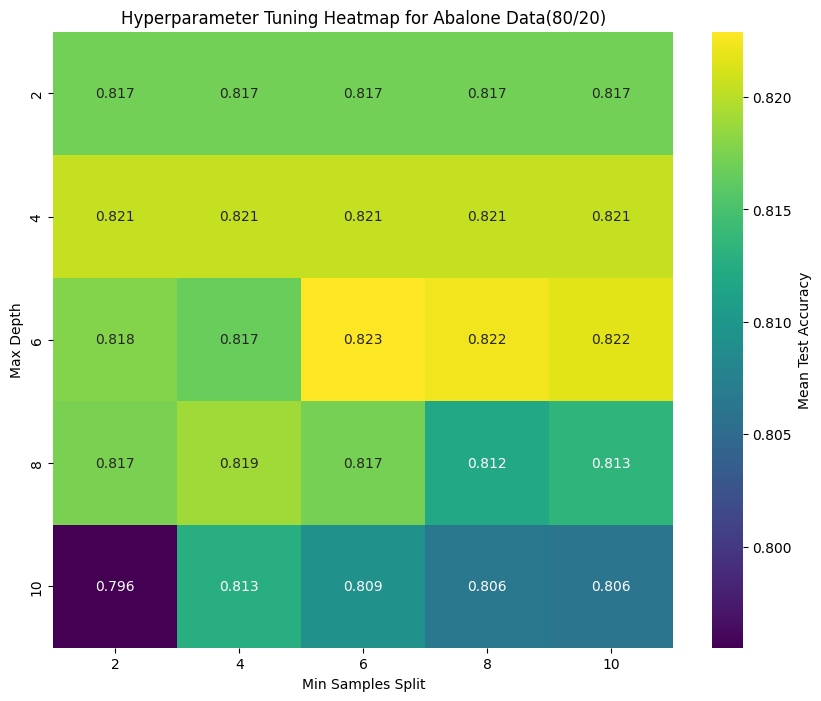

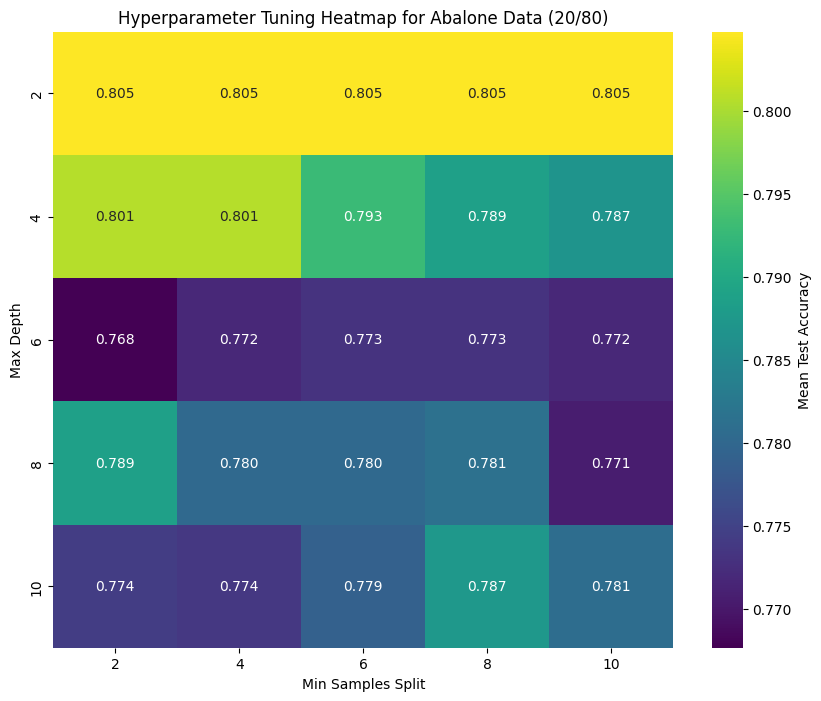

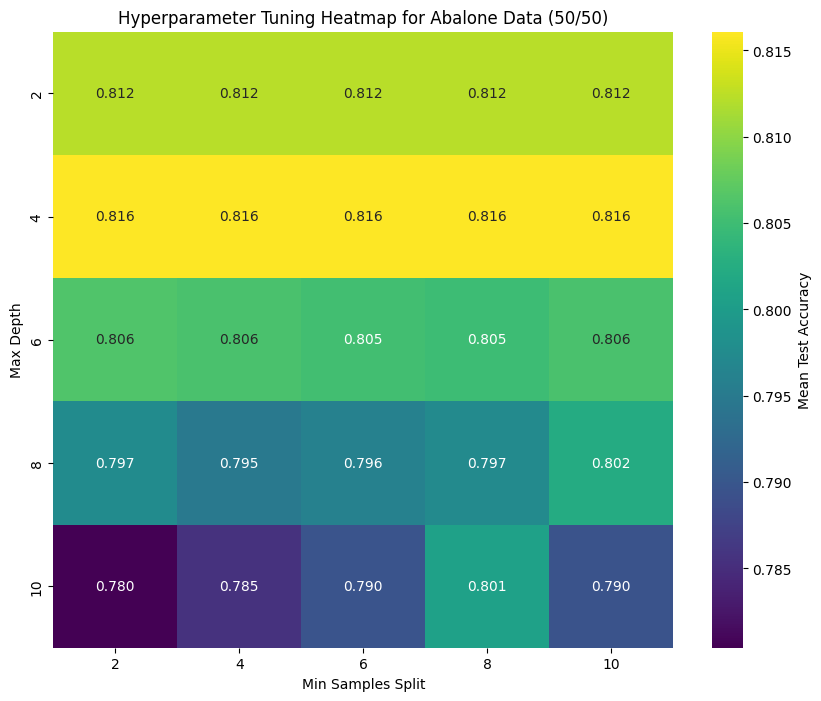

In [25]:
results_80_20 = pd.DataFrame(dt_grid_80_20.cv_results_)
heatmap_data = results_80_20.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for Abalone Data(80/20)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

results_20_80 = pd.DataFrame(dt_grid_20_80.cv_results_)
heatmap_data = results_20_80.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for Abalone Data (20/80)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

results_50_50 = pd.DataFrame(dt_grid_50_50.cv_results_)
heatmap_data = results_50_50.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for Abalone Data (50/50)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

### Accuracy Curve for each Abalone Partition

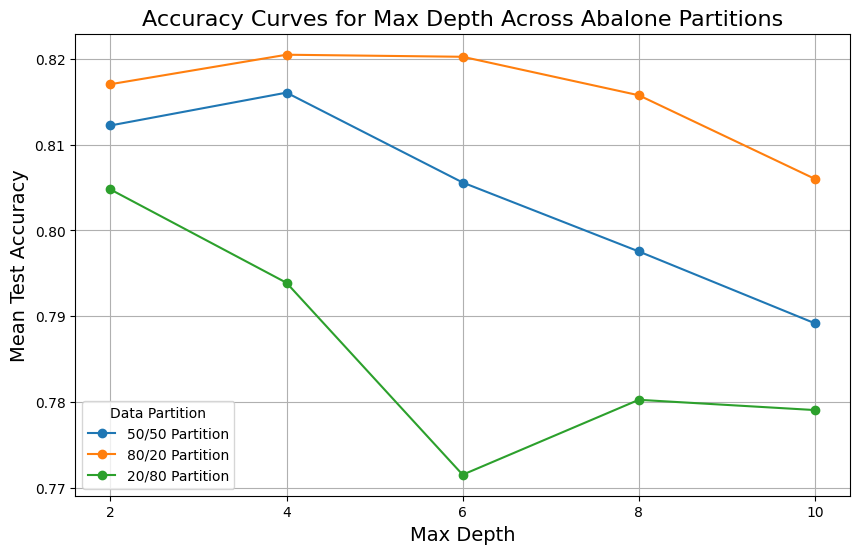

In [26]:
partitions = {
    '50/50': results_50_50,
    '80/20': results_80_20,
    '20/80': results_20_80
}

plt.figure(figsize=(10, 6))

for partition_name, results in partitions.items():
    # Group results by max_depth and calculate mean test score
    accuracy_curve_data = results.groupby('param_max_depth')['mean_test_score'].mean()
    
    # Plot the accuracy curve for the current partition
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition'
    )

# Add labels, title, legend, and grid
plt.title('Accuracy Curves for Max Depth Across Abalone Partitions', fontsize=16)
plt.xlabel('Max Depth', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)  # Ensure x-ticks match max_depth values
plt.show()

### Optimal MPG Data Hyper Parameters

In [27]:
#   (80/20)
XM_train_80, XM_test_20, YM_train_80, YM_test_20 = train_test_split(XM, YM, test_size=0.2, random_state=1)
#   (20/80)
XM_train_20, XM_test_80, YM_train_20, YM_test_80 = train_test_split(XM, YM, test_size=0.8, random_state=1)
#   (50/50)
XM_train_50, XM_test_50, YM_train_50, YM_test_50 = train_test_split(XM, YM, test_size=0.5, random_state=1)

In [28]:
#   optimal parameters and test accuracy (80/20)
optimal_params_80_20, dt_grid_80_20, dt = run_grid_search(XM_train_80, YM_train_80, param_grid);
test_accuracy = dt_grid_80_20.score(XM_test_20, YM_test_20)
train_predictions = dt_grid_80_20.predict(XM_train_80)
train_accuracy = accuracy_score(YM_train_80, train_predictions)
cv_scores = cross_val_score(dt, XM_train_80, YM_train_80, cv=5)

print('Optimal Parameters (80/20):', optimal_params_80_20)
print(f'Test Accuracy (80/20): {test_accuracy:.3f}')
print(f"Train Accuracy (80/20): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (80/20): DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=6, random_state=1)
Test Accuracy (80/20): 0.911
Train Accuracy (80/20): 0.9775641025641025
Cross Validation Scores: [0.88888889 0.9047619  0.93548387 0.88709677 0.88709677]


In [29]:
#   optimal parameters and test accuracy (20/80)
optimal_params_20_80, dt_grid_20_80, dt = run_grid_search(XM_train_20, YM_train_20, param_grid);
test_accuracy = dt_grid_20_80.score(XM_test_80, YM_test_80)
train_predictions = dt_grid_20_80.predict(XM_train_20)
train_accuracy = accuracy_score(YM_train_20, train_predictions)
cv_scores = cross_val_score(dt, XM_train_20, YM_train_20, cv=5)

print('Optimal Parameters (20/80):', optimal_params_20_80)
print(f'Test Accuracy (20/80): {test_accuracy:.3f}')
print(f"Train Accuracy (20/80): {train_accuracy}")
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (20/80): DecisionTreeClassifier(max_depth=4, max_features='sqrt', random_state=1)
Test Accuracy (20/80): 0.837
Train Accuracy (20/80): 1.0
Cross Validation Scores: [0.875      0.875      0.8125     0.93333333 1.        ]


In [31]:
#   optimal parameters and test accuracy (50/50)
optimal_params_50_50, dt_grid_50_50, dt = run_grid_search(XM_train_50, YM_train_50, param_grid);
test_accuracy = dt_grid_50_50.score(XM_test_50, YM_test_50)
train_predictions = dt_grid_50_50.predict(XM_train_50)
train_accuracy = accuracy_score(YM_train_50, train_predictions)
cv_scores = cross_val_score(dt, XM_train_50, YM_train_50, cv=5)

print('Optimal Parameters (50/50):', optimal_params_50_50)
print(f'Test Accuracy (50/50): {test_accuracy:.3f}')
print(f'Train Accuracy (50/50): {train_accuracy:.3f}')
print(f"Cross Validation Scores: {cv_scores}")

Optimal Parameters (50/50): DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_split=4,
                       random_state=1)
Test Accuracy (50/50): 0.888
Train Accuracy (50/50): 0.990
Cross Validation Scores: [0.76923077 0.94871795 0.92307692 0.84615385 0.92307692]


### Heat Maps for each MPG Partition

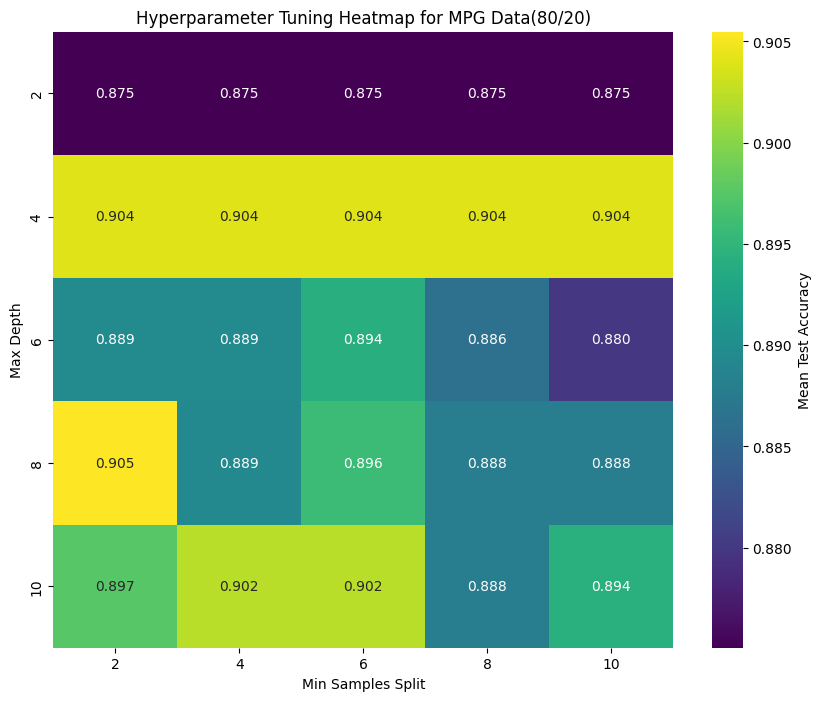

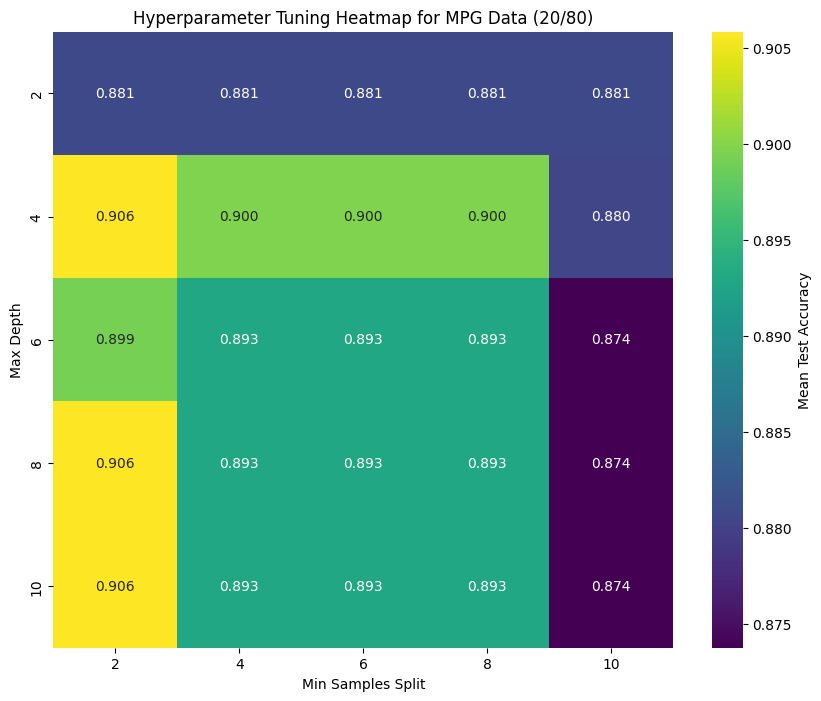

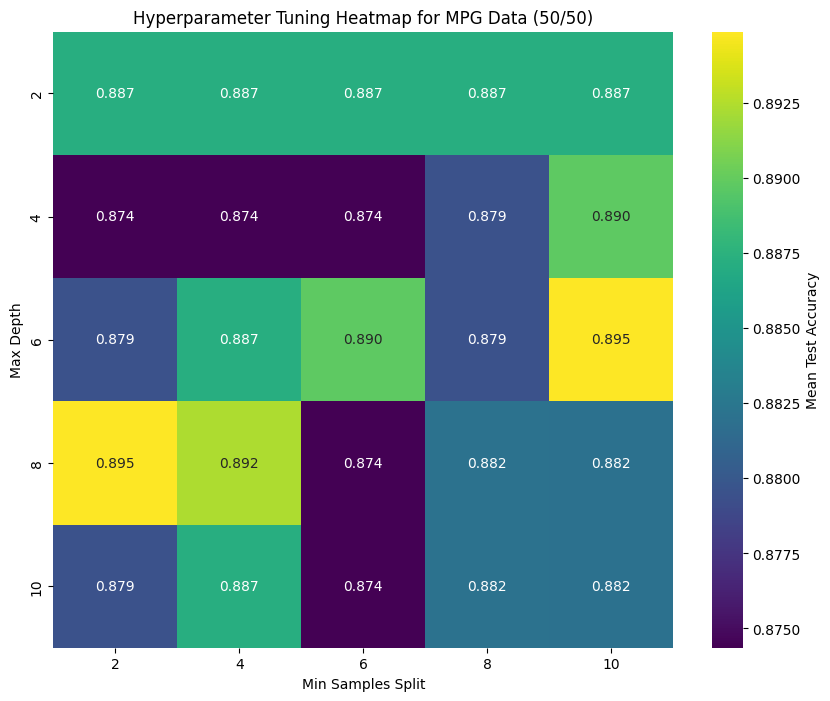

In [32]:
#   heat map
results_80_20 = pd.DataFrame(dt_grid_80_20.cv_results_)
heatmap_data = results_80_20.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for MPG Data(80/20)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

results_20_80 = pd.DataFrame(dt_grid_20_80.cv_results_)
heatmap_data = results_20_80.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for MPG Data (20/80)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()

results_50_50 = pd.DataFrame(dt_grid_50_50.cv_results_)
heatmap_data = results_50_50.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Accuracy'})
plt.title('Hyperparameter Tuning Heatmap for MPG Data (50/50)')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()


### Accuracy Curve for each MPG Partition

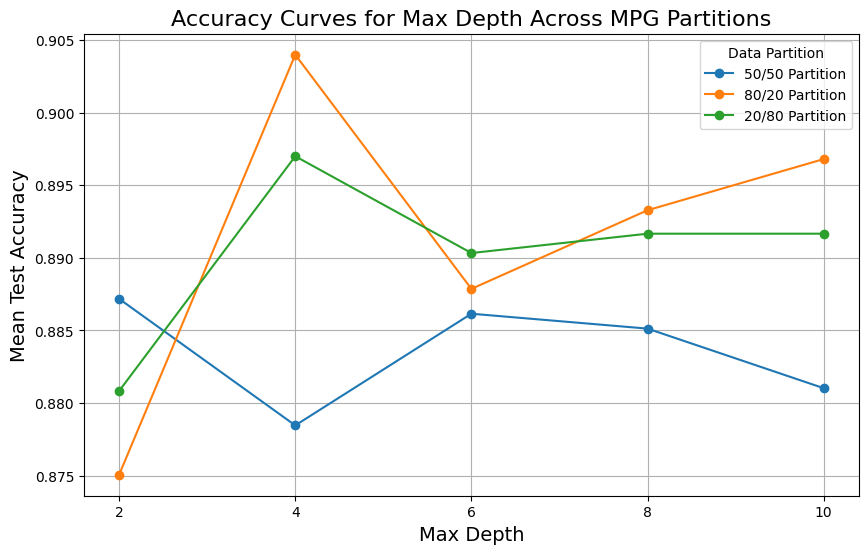

In [33]:
partitions = {
    '50/50': results_50_50,
    '80/20': results_80_20,
    '20/80': results_20_80
}

plt.figure(figsize=(10, 6))

for partition_name, results in partitions.items():
    # Group results by max_depth and calculate mean test score
    accuracy_curve_data = results.groupby('param_max_depth')['mean_test_score'].mean()
    
    # Plot the accuracy curve for the current partition
    plt.plot(
        accuracy_curve_data.index,
        accuracy_curve_data.values,
        marker='o',
        linestyle='-',
        label=f'{partition_name} Partition'
    )

# Add labels, title, legend, and grid
plt.title('Accuracy Curves for Max Depth Across MPG Partitions', fontsize=16)
plt.xlabel('Max Depth', fontsize=14)
plt.ylabel('Mean Test Accuracy', fontsize=14)
plt.grid(True)
plt.legend(title='Data Partition')
plt.xticks(accuracy_curve_data.index)  # Ensure x-ticks match max_depth values
plt.show()